In [157]:
import pandas as pd
import numpy as np
import quandl
import matplotlib
%matplotlib inline

quandl.ApiConfig.api_key = "zFtyXTJz6DTqqdvEy2gi"

In [ ]:
#Stock Data (DBA and WEAT not available from here)
#data = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'close'] }, ticker = ['DBA'], date = { 'gte': '2012-01-01', 'lte': '2018-04-13' })

### Futures: Continuous contracts (W# - contract # ahead)

In [2]:
#continuous futures W1 is front month
#W1 may18 prices start 3/15/18..futures trade until biz day before 15th of settle month
data = quandl.get('CHRIS/CME_W7')

In [3]:
data.to_csv('CME_W7.csv')

In [4]:
data.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2014-12-24,631.5,631.5,631.5,631.0,17.0,631.0,2.0,144.0
2014-12-26,631.0,631.0,631.0,631.0,0.0,631.0,0.0,146.0
2014-12-29,634.5,634.5,634.5,634.5,3.5,634.5,3.0,146.0
2014-12-30,629.0,629.0,625.0,624.5,10.0,624.5,10.0,147.0
2014-12-31,613.0,613.0,613.0,613.0,11.5,613.0,0.0,151.0


### Futures: Individual contracts (all data)

In [ ]:
#individual contract (July 2018)
#data = quandl.get('CME/WN2018')
#data = quandl.get('CME/WK2018')  #may2018'
data = quandl.get('CME/WH2018')  #mar2018


In [ ]:
#data.iloc[635:,[3]]

### Combining the Financial data sets by Date

In [65]:
# dat = pd.read_csv("Data/CME_W4.csv")
# dat = dat.rename(index=str, columns={'Volume': 'Vol', 'Previous Day Open Interest': 'OpIntPvD'})
# print(dat.head())
# print(len(dat))
# dat.dtypes

# i = 1
# cols = ['Date', 'Open', 'High', 'Low', 'Last', 'Vol', 'OpInt']
# dat = dat[cols]
# cols2 = ['W'+str(i) + "_" + x for x in cols[1:]]
# cols2.insert(0,'Date')
# dat.columns = cols2
# dat.head()

### Combine all the Futures Contract Data (5 futures files (W1-W5) and 4 stocks )

In [25]:
def fixDate(inDate):
    lst = inDate.split('/')
    if lst[2] < '20':
        lst[2] = '20'+lst[2]
    else:
        lst[2] = '19'+lst[2]
    return '/'.join(lst)
    
import glob

cols = ['Date', 'Open', 'High', 'Low', 'Last', 'Vol', 'OpInt']

#get futures data files, sort by 13th char (digit)
filenamesFUT = glob.glob('./Data/CME_W*.csv')
filenamesFUT = sorted(filenamesFUT, key=lambda x: x[12])

#for each file, subset/clean columns, join to W1 by date
for file in filenamesFUT:
    lst = file.split('W')
    cNum = int(lst[1][:1])
    df = pd.read_csv(file)
    
    #W1-3 have date without century, add full year
    if cNum <= 3:
        df['Date'] = df['Date'].apply(fixDate)
    df['Date'] = pd.to_datetime(df['Date'])
    
    df = df.rename(index=str, columns={'Volume': 'Vol', 'Previous Day Open Interest': 'OpInt'})
    df = df[cols]
    colsTxt = ['W'+str(cNum) + "_" + x for x in cols[1:]]
    colsTxt.insert(0, 'Date')
    df.columns = colsTxt

    if cNum == 1:
        dat = df
    else:
        dat = dat.merge(df, how='left', on='Date')



### Add Equity data

In [26]:
filenames = glob.glob('./Data/*.csv')
filenamesEQ = [x for x in filenames if x not in filenamesFUT]

colsEQ = ['Date','Close']

for file in filenamesEQ:
    if 'financialALL' not in file and 'pivoted' not in file:
        df = pd.read_csv(file, parse_dates=[0])
        df = df[colsEQ]
    
        #extract ticker
        ticker = file.split('/')[2].split('.')[0]

        df.columns = ['Date', ticker]
        
        #merge with futures data
        dat = dat.merge(df, how='left', on='Date')

In [27]:
dat.columns

Index(['Date', 'W1_Open', 'W1_High', 'W1_Low', 'W1_Last', 'W1_Vol', 'W1_OpInt',
       'W2_Open', 'W2_High', 'W2_Low', 'W2_Last', 'W2_Vol', 'W2_OpInt',
       'W3_Open', 'W3_High', 'W3_Low', 'W3_Last', 'W3_Vol', 'W3_OpInt', 'ADM',
       'BG', 'WEAT', 'DBA'],
      dtype='object')

In [155]:
# make Date the index
dat = dat.set_index('Date')

In [29]:
#save to csv
dat.to_csv("./Data/financialALL.csv")

In [23]:
#dfW = pd.read_csv("./Data/pivoted_daily.csv", header=0, dtype=np.float64)
#dfW.head()

In [24]:
dat.head()

,Date,W1_Open,W1_High,W1_Low,W1_Last,W1_Vol,W1_OpInt,W2_Open,W2_High,W2_Low,...,W5_Open,W5_High,W5_Low,W5_Last,W5_Vol,W5_OpInt,ADM,BG,WEAT,DBA
0,1959-07-01,195.7,196.7,195.7,196.4,5828,25273,199.3,200.1,199.2,...,185.2,185.2,185.0,185.0,75.0,2382.0,NaN,NaN,NaN,NaN
1,1959-07-02,196.3,197.4,196.3,197.1,4780,26524,199.7,200.2,199.5,...,184.6,185.5,184.6,185.2,20.0,2402.0,NaN,NaN,NaN,NaN
2,1959-07-06,196.6,197.6,196.6,197.0,6591,27452,200.0,200.6,200.0,...,185.2,185.2,185.2,185.2,20.0,2402.0,NaN,NaN,NaN,NaN
3,1959-07-07,197.3,197.5,196.7,197.1,5604,28749,200.6,200.6,199.5,...,185.1,185.5,185.0,185.5,0.0,2402.0,NaN,NaN,NaN,NaN
4,1959-07-08,197.2,197.4,196.3,196.4,4538,30527,200.0,200.0,198.3,...,185.7,185.7,185.2,185.2,35.0,2422.0,NaN,NaN,NaN,NaN


## Feature Engineering

### OHLC Average

Many traders believe in technical analysis, forecasting prices by analyzing statistics based on trading activity 

In [33]:
#add OHLC for each of the futures contracts
dat['W1_OHLC'] = np.sum(dat[['W1_Open', 'W1_High', 'W1_Low', 'W1_Last']],axis=1) / 4
dat['W2_OHLC'] = np.sum(dat[['W2_Open', 'W2_High', 'W2_Low', 'W2_Last']],axis=1) / 4
dat['W3_OHLC'] = np.sum(dat[['W3_Open', 'W3_High', 'W3_Low', 'W3_Last']],axis=1) / 4

In [38]:
#rearrange the columns
dat = dat[['Date', 'W1_Open', 'W1_High', 'W1_Low', 'W1_Last', 'W1_Vol', 'W1_OpInt', 'W1_OHLC',
       'W2_Open', 'W2_High', 'W2_Low', 'W2_Last', 'W2_Vol', 'W2_OpInt', 'W2_OHLC', 
       'W3_Open', 'W3_High', 'W3_Low', 'W3_Last', 'W3_Vol', 'W3_OpInt', 'W3_OHLC', 'ADM',
       'BG', 'WEAT', 'DBA']]

### Moving Averages

In [149]:
MoveAvg = [50,100,200]
for ma in MoveAvg:
    dat['W1_{}MA'.format(ma)] = dat['W1_Last'].rolling(window=ma).mean()
    dat['W2_{}MA'.format(ma)] = dat['W2_Last'].rolling(window=ma).mean()
    dat['W3_{}MA'.format(ma)] = dat['W3_Last'].rolling(window=ma).mean()

In [150]:
dat.columns

Index(['Date', 'W1_Open', 'W1_High', 'W1_Low', 'W1_Last', 'W1_Vol', 'W1_OpInt',
       'W1_OHLC', 'W2_Open', 'W2_High', 'W2_Low', 'W2_Last', 'W2_Vol',
       'W2_OpInt', 'W2_OHLC', 'W3_Open', 'W3_High', 'W3_Low', 'W3_Last',
       'W3_Vol', 'W3_OpInt', 'W3_OHLC', 'ADM', 'BG', 'WEAT', 'DBA', 'W1_50MA',
       'W2_50MA', 'W3_50MA', 'W1_100MA', 'W2_100MA', 'W3_100MA', 'W1_200MA',
       'W2_200MA', 'W3_200MA'],
      dtype='object')

### Percent Change

In [158]:
dat['W1_PctChg'] = dat['W1_Last'].pct_change()
dat['W2_PctChg'] = dat['W2_Last'].pct_change()
dat['W3_PctChg'] = dat['W3_Last'].pct_change()

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM, RNN, GRU
from keras.models import load_model
import keras
import h5py
import requests
import os

### Normalize the data  (call function for whichever cols we want to normalize)

In [133]:
def normalizeData(data):
    minMax = MinMaxScaler()
    normData = minMax.fit_transform(data.values.reshape(-1,1)).ravel()
    return normData

In [137]:
#normalize a subset of the data
datNorm = dat.iloc[:,1:5].apply(normalizeData, axis=0)

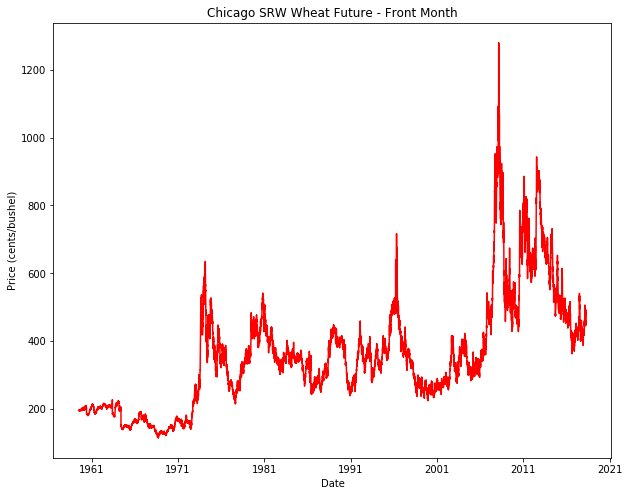

In [185]:
plt.figure(figsize=(10,8))
plt.plot(dat['W1_Last'], color='r', label='W1')
#plt.plot(dat['W1_50MA'], color='b', label='W2')
#plt.plot(dat['W1_100MA'], color='c', label='W3');
plt.xlabel('Date')
plt.ylabel('Price (cents/bushel)')
plt.title('Chicago SRW Wheat Future - Front Month');

### Neural Network (RNN, GRU, LSTM)

In [ ]:
def build_NN(seq, numFeatures, dropRate, nnType='RNN'):
    
    model = Sequential()
    model.add(input_shape=(seq, numFeatures))  #input layer
    
    if nnType == 'RNN':    
        model.add(RNN(64))
        model.add(Dense(40, activation='relu'))
    elif nnType == 'GRU':
        model.add(GRU(64))
        model.add(Dense(1, activation='tanh'))
    elif nnType == 'LSTM':
        model.add(LSTM(64))
        model.add(Dropout(dropRate))
        model.add(LSTM(64))
        model.add(Dense(1, activation='relu'))
    else:
        print('should not be here')
    
    model.add(Dense(1, activation='linear')) #output layer
    #model.summary()   
    
    model.compile(loss='mse', optimizer='adam', metrics='accuracy')
    
    return model

In [ ]:
model = build_NN()

### Prep Data for NN

In [184]:
def prepData(df, window=30):
    
    newData = []

    for i in range(len(df) - window): 
        newData.append(df[i: i + window]) # moving window of data

    result = np.array(result)
    row = round(0.8 * result.shape[0]) # 80% split

    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price

    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))

    return [X_train, y_train, X_test, y_test]

In [ ]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)